### SCOPE Project 2021/22
# EEG Signal Classification of Motor-Imagery BCI Data

Group 1:
- Ana Lopes, no. 98587
- Daniel Galhoz, no. 90791
- Diogo Batista, no. 86767

## Initialization



In [ ]:
# Import data with $bash into /content (182.4 MB)
![ -f /content/Datasets.zip ] && echo "dataset exists" || wget 'https://my.laseeb.org/~thanos/bci/data/Datasets.zip'

--2021-11-14 20:21:33--  https://my.laseeb.org/~thanos/bci/data/Datasets.zip
Resolving my.laseeb.org (my.laseeb.org)... 193.136.138.6
Connecting to my.laseeb.org (my.laseeb.org)|193.136.138.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182408969 (174M) [application/zip]
Saving to: ‘Datasets.zip’

Datasets.zip        100%[===================>] 173.96M  27.3MB/s    in 7.8s    

2021-11-14 20:21:42 (22.2 MB/s) - ‘Datasets.zip’ saved [182408969/182408969]



In [ ]:
# Unzip data into "Datasets" directory
!unzip Datasets.zip -d Datasets

Archive:  Datasets.zip
  inflating: Datasets/S04.gdf        
  inflating: Datasets/S11.gdf        
  inflating: Datasets/S12.gdf        
  inflating: Datasets/S06.gdf        
  inflating: Datasets/S05.gdf        
  inflating: Datasets/S03.gdf        
  inflating: Datasets/S07.gdf        
  inflating: Datasets/S10.gdf        
  inflating: Datasets/S08.gdf        
  inflating: Datasets/S02.gdf        
  inflating: Datasets/S09.gdf        
  inflating: Datasets/S01.gdf        


In [ ]:
# Find pathnames to loop from
import glob, os

data_path = '/content/Datasets/'

os.chdir(data_path)

for file in glob.glob("*.gdf"):
  print(file)

S05.gdf
S02.gdf
S11.gdf
S10.gdf
S09.gdf
S07.gdf
S08.gdf
S04.gdf
S01.gdf
S12.gdf
S03.gdf
S06.gdf


In [ ]:
# Install MNE into Colab
try:
  import mne
  print('mne: {}'.format(mne.__version__))
except ModuleNotFoundError:
  !pip install mne --upgrade

     |████████████████████████████████| 7.4 MB 3.6 MB/s 


### Classes:


In [ ]:
import numpy  as np
import os
import pandas as pd
import sys

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline        import Pipeline

# Analyzes the best classifier for MI BCI data
# Adapted from https://www.davidsbatista.net/blog/2018/02/23/model_optimization/
class BestClassifierAnalyzer:
    
        # "models": dictionary with the models' names and their classes
        # "parameters": dictionary with the models' names and their parameters
        
        def __init__(self, models, parameters):
            if not set(models.keys()).issubset(set(parameters.keys())):
                missing_parameters = list(set(models.keys() - set(parameters.keys())))
                raise ValueError("Some estimators are missing parameters: %s" % missing_parameters)
            self.models = models
            self.parameters = parameters
            self.keys = models.keys()
            self.grid_searches = {}
            self.all_parameters=[]
            
        def fit(self, X, y, csp, cv, scoring = 'accuracy', n_jobs = 1, verbose = 1, refit = False):
            for key in self.keys:
                print("Running GridSearchCV for %s." % key)
                model = self.models[key]
                parameters = self.parameters[key]
                classifier = Pipeline(steps = [('csp', csp), ('clf', model)])
                grid_search = GridSearchCV(classifier, parameters,
                                           cv = cv,
                                           n_jobs = n_jobs,
                                           verbose = verbose,
                                           scoring = scoring,
                                           refit = refit,
                                           return_train_score = True)
                grid_search.fit(X, y)
                self.grid_searches[key] = grid_search
                
        def score_summary(self, sort_by = 'mean_score'):
            def row(key, scores, parameters, other_scores, times):
                entry = {
                    'classifier': key,
                         
                    'min_score' : min(scores),
                    'max_score' : max(scores),
                    'mean_score': np.mean(scores),
                    'std_score' : np.std(scores),
                         
                    'balanced_accuracy'   : other_scores[0],
                    'mean_precision_left' : other_scores[1],
                    'mean_precision_right': other_scores[2],
                    'mean_recall_left'    : other_scores[3],
                    'mean_recall_right'   : other_scores[4],

                    'mean_fit_time'  : times[0],
                    'std_fit_time'   : times[1],
                    'mean_score_time': times[2],
                    'std_score_time' : times[3]
                    }
                return pd.Series({**parameters, **entry})
            
            rows = []
            
            for k in self.grid_searches:
                parameters = self.grid_searches[k].cv_results_['params']

                scores = []
                for i in range(self.grid_searches[k].n_splits_):
                    key = "split{}_test_accuracy".format(i)
                    r = self.grid_searches[k].cv_results_[key]
                    scores.append(r.reshape(len(parameters), 1))            
                all_scores = np.hstack(scores)
            
                # Other score metrics
                other_scores = []
                
                r = self.grid_searches[k].cv_results_["mean_test_balanced_accuracy"]
                other_scores.append(r.reshape(len(parameters), 1))

                r = self.grid_searches[k].cv_results_["mean_test_precision_left"]
                other_scores.append(r.reshape(len(parameters), 1))

                r = self.grid_searches[k].cv_results_["mean_test_precision_right"]
                other_scores.append(r.reshape(len(parameters), 1))

                r = self.grid_searches[k].cv_results_["mean_test_recall_left"]
                other_scores.append(r.reshape(len(parameters), 1))

                r = self.grid_searches[k].cv_results_["mean_test_recall_right"]
                other_scores.append(r.reshape(len(parameters), 1))

                all_other_scores = np.hstack(other_scores)

                # Computation times
                times = []

                r = self.grid_searches[k].cv_results_["mean_fit_time"]
                times.append(r.reshape(len(parameters), 1))

                r = self.grid_searches[k].cv_results_["std_fit_time"]
                times.append(r.reshape(len(parameters), 1))

                r = self.grid_searches[k].cv_results_["mean_score_time"]
                times.append(r.reshape(len(parameters), 1))

                r = self.grid_searches[k].cv_results_["std_score_time"]
                times.append(r.reshape(len(parameters), 1))

                all_times = np.hstack(times)

                # Assemble every parameter and their values for the table
                for p, s, o_s, t in zip(parameters, all_scores, all_other_scores, all_times):
                    rows.append((row(k, s, p, o_s, t)))
                    
            df = pd.concat(rows, axis = 1).T.sort_values([sort_by], ascending = False)
            
            columns = ['classifier', 'min_score', 'mean_score', 'max_score', 'std_score', 'balanced_accuracy', 
                       'mean_precision_left','mean_precision_right','mean_recall_left','mean_recall_right',
                       'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time']
            self.all_parameters = [c for c in df.columns if c not in columns]
            columns = columns + self.all_parameters
            
            return df[columns]


# Blocks calls to print
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
# General libraries
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn           as sns

# Pipeline and auxiliary functions
from sklearn.model_selection import cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.pipeline        import Pipeline
from sklearn.metrics         import make_scorer, precision_score, recall_score

# MNE
from mne          import Epochs, events_from_annotations, pick_types
from mne.channels import find_layout, make_standard_montage, read_custom_montage
from mne.decoding import CSP
from mne.io       import read_raw_gdf, read_raw_eeglab

# Classifier imports
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble              import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes           import GaussianNB
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.neural_network        import MLPClassifier
from sklearn.svm                   import SVC

# Statistical tests
from scipy.stats import kruskal, wilcoxon

# Enable data table display
from google.colab import data_table
data_table.enable_dataframe_formatter()

# Pandas settings
pd.set_option('display.max_rows'    , None)
pd.set_option('display.max_columns' , None)
pd.set_option('display.width'       , None)
pd.set_option('display.max_colwidth', None)

In [ ]:
# Cross-validation parameters
cv = ShuffleSplit(10, test_size = 0.2, random_state = 42)

# Common spatial pattern filter
csp = CSP(n_components = 4, reg = None, log = True, norm_trace = False)

# Models and hyperparameters to be tested
models = {
    # https://scikit-learn.org/stable/supervised_learning.html
    'LDA': LinearDiscriminantAnalysis(),
    'SVC': SVC(),
    'MLP': MLPClassifier(),
    'KNN': KNeighborsClassifier(),
    'GaussianNB': GaussianNB(),
    'RandomForest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier()
    }

params = {
    # https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
    'LDA': [{'clf__solver': ['svd']},
            {'clf__solver': ['lsqr', 'eigen'], 'clf__shrinkage': ['auto', 0.1, 0.2, 0.5]}],
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    'SVC': [{'clf__kernel': ['linear'], 'clf__C': [1, 10]},
            {'clf__kernel': ['rbf']   , 'clf__C': [1, 10], 'clf__gamma': [0.001, 0.0001]}],
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
    'MLP': [{'clf__hidden_layer_sizes': [(50,), (100,), (150,)], 
             'clf__activation'        : ['relu', 'logistic', 'tanh'], 
             'clf__learning_rate'     : ['constant', 'adaptive'],
             'clf__early_stopping'    : [False, True]}],
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    'KNN': [{'clf__n_neighbors': [3, 5, 7], 
             'clf__weights'    : ['uniform', 'distance']}],
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
    'GaussianNB': {},
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    'RandomForest': [{'clf__n_estimators': [10, 100, 150], 
                      'clf__criterion'   : ['gini', 'entropy']}],
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
    'AdaBoost': [{'clf__n_estimators' : [10, 50, 100],
                  'clf__learning_rate': [0.5, 0.8, 1.0, 1.2],
                  'clf__algorithm'    : ['SAMME', 'SAMME.R']}]
    }

     # Best parameters per model
results = {
    'LDA': [],
    'SVC': [],
    'MLP': [],   
    'KNN': [],
    'GaussianNB': [],
    'RandomForest': [],
    'AdaBoost': []
    }

output_tables = {}

# For the left hand
prec_score_left = make_scorer(precision_score, pos_label = 0)
rec_score_left = make_scorer(recall_score, pos_label = 0)

# For the right hand
prec_score_right = make_scorer(precision_score, pos_label = 1)
rec_score_right = make_scorer(recall_score, pos_label = 1)

scoring = {
    'accuracy'         : 'accuracy', 
    'balanced_accuracy': 'balanced_accuracy', 
    'precision_left'   : prec_score_left, 
    'precision_right'  : prec_score_right,
    'recall_left'      : rec_score_left, 
    'recall_right'     : rec_score_right
    }

---
## Preprocessing and classification

In [ ]:
for file in glob.glob("*.gdf"):
  
  print()
  print(file)

  # PREPROCESSING
  with HiddenPrints():
    # Exclude ACC channels
    ex_chans = ['Channel 33', 'Channel 34', 'Channel 35']

    # Import data
    raw = read_raw_gdf(file, exclude = ex_chans, stim_channel = -1, preload = True) # .gdf

    # Create montage from channel locations
    ch_names = raw.ch_names
    montage = make_standard_montage('biosemi32')
    # montage.plot(kind = 'topomap', show_names = True)
    ch_loc = montage.ch_names
    c = dict(zip(ch_names, ch_loc)) # Combine names with locations
    raw.rename_channels(c)
    raw.set_montage(montage)

    # Apply band-pass filter
    raw.filter(8., 30., fir_design = 'firwin', skip_by_annotation = 'edge')

    # Epoch data between -2 seconds and +4 seconds during left/right stimuli
    tmin, tmax = -2., 4.
    event_id = dict(left = 7, right = 8) # OV markers
    events, _ = events_from_annotations(raw, event_id = 'auto')

    picks = pick_types(raw.info, meg = False, eeg = True, stim = False, eog = False, exclude = 'bads')

    epochs = Epochs(raw, events, event_id, tmin, tmax, proj = True, picks = picks, baseline = None, preload = True)
    epochs_train = epochs.copy().crop(tmin = 1., tmax = 4.)
    labels = epochs.events[:, -1] - 7 # Change labels into either 0 or 1

    epochs_data = epochs.get_data()
    epochs_data_train = epochs_train.get_data()

  # CLASSIFICATION
    # Cross-validation sets
    cv_split = cv.split(epochs_data_train)

  # Best classifier analyzer
  bca = BestClassifierAnalyzer(models, params)
  bca.fit(epochs_data_train, labels, csp, cv = cv, scoring = scoring, n_jobs = -1, verbose = 0, refit = False)
  
  output_tables[file] = bca.score_summary()

  for key in bca.keys:
    patient_table = output_tables[file]
    classifier_table = patient_table[patient_table['classifier'] == key]

    classifier_score_column = classifier_table['mean_score'].apply(pd.to_numeric)
    best_result = classifier_score_column.idxmax()

    results[key].append([classifier_table['mean_score'          ][best_result],
                         classifier_table['balanced_accuracy'   ][best_result],
                         classifier_table['mean_precision_left' ][best_result],
                         classifier_table['mean_precision_right'][best_result],
                         classifier_table['mean_recall_left'    ][best_result],
                         classifier_table['mean_recall_right'   ][best_result],
                         classifier_table['mean_fit_time'       ][best_result],
                         classifier_table.loc[[best_result], bca.all_parameters]])

np.save('output_tables.npy', output_tables)
np.save('results.npy', results)


S05.gdf


<ipython-input-9-6dedd3efda8d>:21: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Cz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)


Running GridSearchCV for LDA.
Running GridSearchCV for SVC.
Running GridSearchCV for MLP.
Running GridSearchCV for KNN.
Running GridSearchCV for GaussianNB.
Running GridSearchCV for RandomForest.
Running GridSearchCV for AdaBoost.

S02.gdf


<ipython-input-9-6dedd3efda8d>:21: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Cz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)


Running GridSearchCV for LDA.
Running GridSearchCV for SVC.
Running GridSearchCV for MLP.
Running GridSearchCV for KNN.
Running GridSearchCV for GaussianNB.
Running GridSearchCV for RandomForest.
Running GridSearchCV for AdaBoost.

S11.gdf


<ipython-input-9-6dedd3efda8d>:21: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Cz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)


Running GridSearchCV for LDA.
Running GridSearchCV for SVC.
Running GridSearchCV for MLP.
Running GridSearchCV for KNN.
Running GridSearchCV for GaussianNB.
Running GridSearchCV for RandomForest.
Running GridSearchCV for AdaBoost.

S10.gdf


<ipython-input-9-6dedd3efda8d>:21: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Cz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)


Running GridSearchCV for LDA.
Running GridSearchCV for SVC.
Running GridSearchCV for MLP.
Running GridSearchCV for KNN.
Running GridSearchCV for GaussianNB.
Running GridSearchCV for RandomForest.
Running GridSearchCV for AdaBoost.

S09.gdf


<ipython-input-9-6dedd3efda8d>:21: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Cz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)


Running GridSearchCV for LDA.
Running GridSearchCV for SVC.
Running GridSearchCV for MLP.
Running GridSearchCV for KNN.
Running GridSearchCV for GaussianNB.
Running GridSearchCV for RandomForest.
Running GridSearchCV for AdaBoost.

S07.gdf


<ipython-input-9-6dedd3efda8d>:21: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Cz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)


Running GridSearchCV for LDA.
Running GridSearchCV for SVC.
Running GridSearchCV for MLP.
Running GridSearchCV for KNN.
Running GridSearchCV for GaussianNB.
Running GridSearchCV for RandomForest.
Running GridSearchCV for AdaBoost.

S08.gdf


<ipython-input-9-6dedd3efda8d>:21: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Cz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)


Running GridSearchCV for LDA.
Running GridSearchCV for SVC.
Running GridSearchCV for MLP.
Running GridSearchCV for KNN.
Running GridSearchCV for GaussianNB.
Running GridSearchCV for RandomForest.
Running GridSearchCV for AdaBoost.

S04.gdf


<ipython-input-9-6dedd3efda8d>:21: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Cz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)


Running GridSearchCV for LDA.
Running GridSearchCV for SVC.
Running GridSearchCV for MLP.
Running GridSearchCV for KNN.
Running GridSearchCV for GaussianNB.
Running GridSearchCV for RandomForest.
Running GridSearchCV for AdaBoost.

S01.gdf


<ipython-input-9-6dedd3efda8d>:21: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Cz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)


Running GridSearchCV for LDA.
Running GridSearchCV for SVC.
Running GridSearchCV for MLP.
Running GridSearchCV for KNN.
Running GridSearchCV for GaussianNB.
Running GridSearchCV for RandomForest.
Running GridSearchCV for AdaBoost.

S12.gdf


<ipython-input-9-6dedd3efda8d>:21: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Cz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)


Running GridSearchCV for LDA.
Running GridSearchCV for SVC.
Running GridSearchCV for MLP.
Running GridSearchCV for KNN.
Running GridSearchCV for GaussianNB.
Running GridSearchCV for RandomForest.
Running GridSearchCV for AdaBoost.

S03.gdf


<ipython-input-9-6dedd3efda8d>:21: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Cz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)


Running GridSearchCV for LDA.
Running GridSearchCV for SVC.
Running GridSearchCV for MLP.
Running GridSearchCV for KNN.
Running GridSearchCV for GaussianNB.
Running GridSearchCV for RandomForest.
Running GridSearchCV for AdaBoost.

S06.gdf


<ipython-input-9-6dedd3efda8d>:21: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Cz']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage(montage)


Running GridSearchCV for LDA.
Running GridSearchCV for SVC.
Running GridSearchCV for MLP.
Running GridSearchCV for KNN.
Running GridSearchCV for GaussianNB.
Running GridSearchCV for RandomForest.
Running GridSearchCV for AdaBoost.


## Results

### Box plots

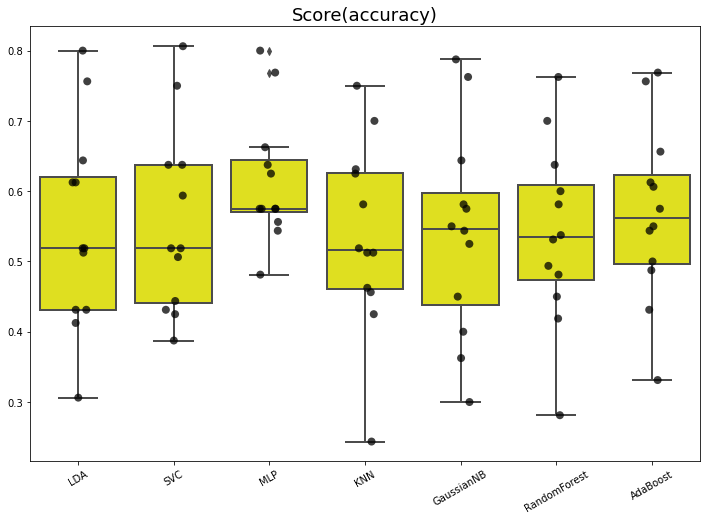

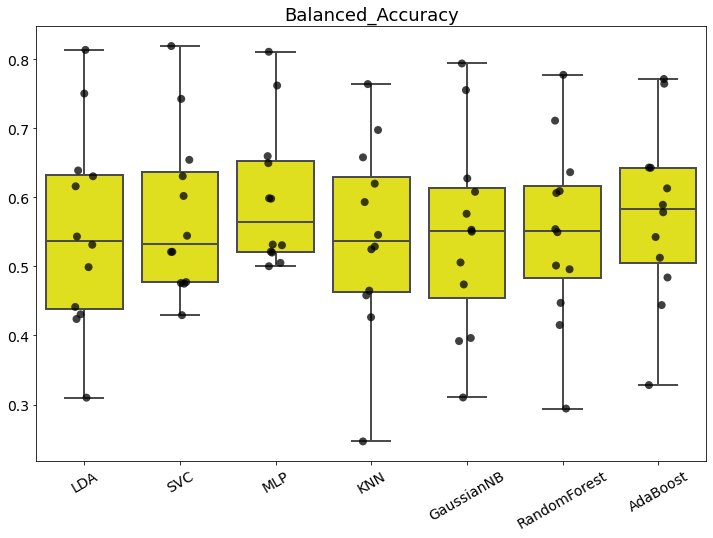

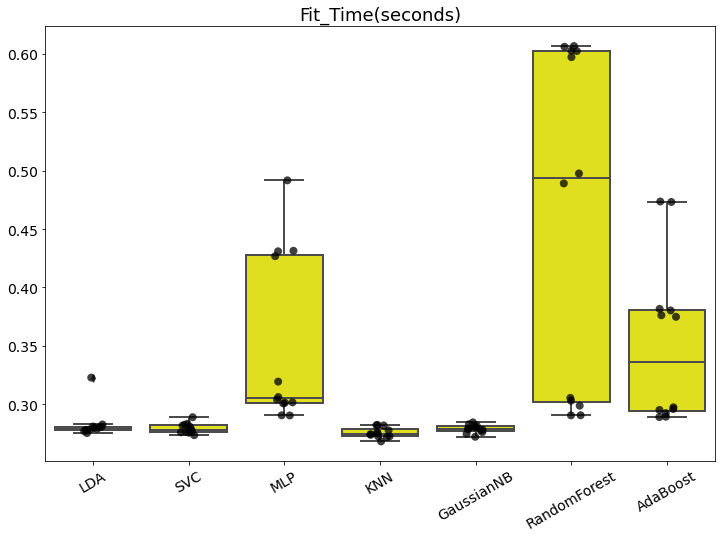

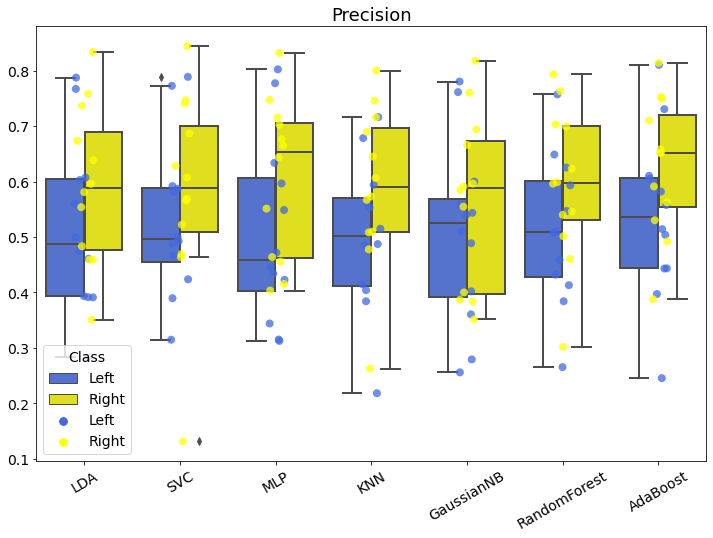

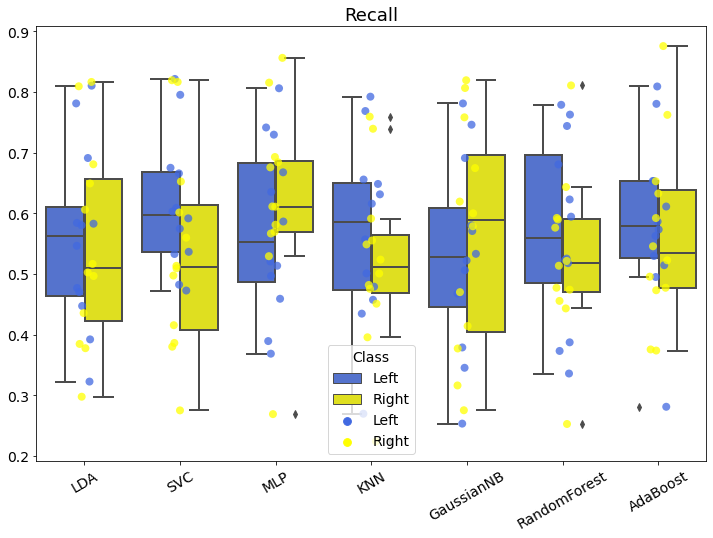

In [ ]:
def my_boxplot(df, x, y, hue, palette):
  SMALL_SIZE  = 14
  MEDIUM_SIZE = 18
  LARGE_SIZE  = 22

  plt.figure(figsize = (12, 8))
  plt.xticks(rotation = 30)

  plt.rc('font'  , size      = SMALL_SIZE ) # Controls default text sizes
  plt.rc('axes'  , titlesize = SMALL_SIZE ) # Fontsize of the axes' title
  plt.rc('axes'  , labelsize = MEDIUM_SIZE) # Fontsize of the x and y labels
  plt.rc('xtick' , labelsize = SMALL_SIZE ) # Fontsize of the tick labels
  plt.rc('ytick' , labelsize = SMALL_SIZE ) # Fontsize of the tick labels
  plt.rc('legend', fontsize  = SMALL_SIZE ) # Legend's fontsize
  plt.rc('figure', titlesize = LARGE_SIZE ) # Fontsize of the figure title

  sns.boxplot(data = df, x = x, y = y, hue = hue, palette = palette, linewidth = 2)
  
  # Data points
  if hue == None:
    color = 'black'
    palette = None
  else:
    color = None

  sns.stripplot(data = df, x = x, y = y, hue = hue, palette = palette, size = 8, color = color, alpha = 0.75)

  plt.title(y, fontsize = 18)

  plt.xlabel('')
  plt.ylabel('')

  plt.show()


# Be sure to upload the file beforehand!
results = np.load('/content/results.npy', allow_pickle = True)
results = results.item()

df_results_list = []
for key in results.keys():
  df_results_list.append(pd.DataFrame(data = results.get(key), 
                                      columns = ['Score(accuracy)',
                                                 'Balanced_Accuracy', 
                                                 'Precision_Left', 
                                                 'Precision_Right', 
                                                 'Recall_Left', 
                                                 'Recall_Right', 
                                                 'Fit_Time(seconds)', 
                                                 'Hyper_Parameters']))
  df_results_list[-1]['Classifier'] = key
  df_results_list[-1]['Patient']    = df_results_list[-1].index

df_results = pd.concat(df_results_list, ignore_index = True)

score_boxplot    = my_boxplot(df = df_results, x = 'Classifier', y = 'Score(accuracy)'  , hue = None, palette = ['yellow'])
balanced_boxplot = my_boxplot(df = df_results, x = 'Classifier', y = 'Balanced_Accuracy', hue = None, palette = ['yellow'])
time_boxplot     = my_boxplot(df = df_results, x = 'Classifier', y = 'Fit_Time(seconds)', hue = None, palette = ['yellow'])

# Left- and right-hand MI classes for precision and recall box plots
df_left = pd.DataFrame(columns = ['Classifier', 'Precision', 'Recall', 'Class'])
df_left['Classifier'] = df_results['Classifier'].copy()
df_left['Precision']  = df_results['Precision_Left'].copy()
df_left['Recall']     = df_results['Recall_Left'].copy()
df_left['Class']      = 'Left'

df_right = pd.DataFrame(columns=['Classifier', 'Precision', 'Recall', 'Class'])
df_right['Classifier'] = df_results['Classifier'].copy()
df_right['Precision']  = df_results['Precision_Right'].copy()
df_right['Recall']     = df_results['Recall_Right'].copy()
df_right['Class']      = 'Right'

df_nested = pd.concat([df_left, df_right], keys = ['left', 'right'], ignore_index = True)

precision_boxplot = my_boxplot(df = df_nested, x = 'Classifier', y = 'Precision', hue = 'Class', palette = ['royalblue', 'yellow'])
recall_boxplot    = my_boxplot(df = df_nested, x = 'Classifier', y = 'Recall'   , hue = 'Class', palette = ['royalblue', 'yellow'])

# for key in results.keys():
#   print('\nBest hyper parameters for: {}\n'.format(key))
#   print(df_results[df_results['Classifier']==key]['Hyper_Parameters'])
#   print('\n')

### Wilcoxon tests

Tests the null hypothesis that two paired score distributions come from the same distribution.

In [ ]:
score_metric_list = ['Accuracy', 
                     'Balanced accuracy', 
                     'Left-hand precision', 'Right-hand precision', 
                     'Left-hand recall'   , 'Right-hand recall',
                     'Fit time']
classifier_list = ['LDA', 
                   'SVC', 
                   'MLP', 
                   'KNN', 
                   'GaussianNB', 
                   'RandomForest', 
                   'AdaBoost']

# p-value matrices for each score metric
pval_matrix = np.zeros(shape = (len(score_metric_list), 
                                len(classifier_list), len(classifier_list)),
                       dtype = 'object') # For ragged nested sequences

for score_metric_idx in range(len(score_metric_list)):
    for clf1 in classifier_list:
        for clf2 in classifier_list:
            if clf1 != clf2:
                # For easier manipulation
                r1 = np.array(results[clf1], dtype = 'object')
                r2 = np.array(results[clf2], dtype = 'object')
                
                clf1_idx = classifier_list.index(clf1)
                clf2_idx = classifier_list.index(clf2)
                
                score_distribution1 = r1[:, score_metric_idx]
                score_distribution2 = r2[:, score_metric_idx]
                
                _, pval_matrix[score_metric_idx, clf1_idx, clf2_idx] = wilcoxon(score_distribution1, score_distribution2)
                
# Convert to Pandas dataframes
df_list = list()
for score_metric_idx in range(len(score_metric_list)):
  df_pvals = pd.DataFrame(pval_matrix[score_metric_idx, :, :], 
                          columns = classifier_list,
                          index   = classifier_list)
  df_pvals.index.name = score_metric_list[score_metric_idx]
  df_list.append(df_pvals)

In [ ]:
df_list[0].style.applymap(lambda x: "background-color: #00C957" if 0 < x < 0.05 else "background-color: None")

,LDA,SVC,MLP,KNN,GaussianNB,RandomForest,AdaBoost
Accuracy,,,,,,,
LDA,0,0.443994,0.003330,0.254425,0.397136,0.271726,0.114128
SVC,0.443994,0,0.004420,0.141974,0.307635,0.229794,0.350052
MLP,0.003330,0.004420,0,0.002209,0.002218,0.002209,0.007963
KNN,0.254425,0.141974,0.002209,0,0.504739,0.755424,0.012030
GaussianNB,0.397136,0.307635,0.002218,0.504739,0,0.789472,0.073567
RandomForest,0.271726,0.229794,0.002209,0.755424,0.789472,0,0.003228
AdaBoost,0.114128,0.350052,0.007963,0.012030,0.073567,0.003228,0


In [ ]:
df_list[1].style.applymap(lambda x: "background-color: #00C957" if 0 < x < 0.05 else "background-color: None")

,LDA,SVC,MLP,KNN,GaussianNB,RandomForest,AdaBoost
Balanced accuracy,,,,,,,
LDA,0,0.157939,0.022909,0.582920,0.480177,0.307821,0.071189
SVC,0.157939,0,0.034170,0.049860,0.059739,0.084379,0.388186
MLP,0.022909,0.034170,0,0.018603,0.009633,0.012063,0.239317
KNN,0.582920,0.049860,0.018603,0,0.875329,0.530285,0.022909
GaussianNB,0.480177,0.059739,0.009633,0.875329,0,0.694887,0.041389
RandomForest,0.307821,0.084379,0.012063,0.530285,0.694887,0,0.002873
AdaBoost,0.071189,0.388186,0.239317,0.022909,0.041389,0.002873,0


In [ ]:
df_list[2].style.applymap(lambda x: "background-color: #00C957" if 0 < x < 0.05 else "background-color: None")

,LDA,SVC,MLP,KNN,GaussianNB,RandomForest,AdaBoost
Left-hand precision,,,,,,,
LDA,0,0.157939,1.000000,0.346522,0.530285,0.480177,0.157939
SVC,0.157939,0,0.753684,0.059739,0.272095,0.209427,0.637870
MLP,1.000000,0.753684,0,0.637870,0.813945,0.582920,1.000000
KNN,0.346522,0.059739,0.637870,0,0.480177,0.480177,0.022909
GaussianNB,0.530285,0.272095,0.813945,0.480177,0,0.813945,0.099481
RandomForest,0.480177,0.209427,0.582920,0.480177,0.813945,0,0.116664
AdaBoost,0.157939,0.637870,1.000000,0.022909,0.099481,0.116664,0


In [ ]:
df_list[3].style.applymap(lambda x: "background-color: #00C957" if 0 < x < 0.05 else "background-color: None")

,LDA,SVC,MLP,KNN,GaussianNB,RandomForest,AdaBoost
Right-hand precision,,,,,,,
LDA,0,0.753684,0.813945,1.000000,0.028056,0.694887,0.022909
SVC,0.753684,0,0.637870,0.582920,0.116664,0.937473,0.018603
MLP,0.813945,0.637870,0,0.753684,0.116664,0.432768,0.307821
KNN,1.000000,0.582920,0.753684,0,0.157939,0.937473,0.018603
GaussianNB,0.028056,0.116664,0.116664,0.157939,0,0.239317,0.009633
RandomForest,0.694887,0.937473,0.432768,0.937473,0.239317,0,0.003702
AdaBoost,0.022909,0.018603,0.307821,0.018603,0.009633,0.003702,0


In [ ]:
df_list[4].style.applymap(lambda x: "background-color: #00C957" if 0 < x < 0.05 else "background-color: None")

,LDA,SVC,MLP,KNN,GaussianNB,RandomForest,AdaBoost
Left-hand recall,,,,,,,
LDA,0,0.034170,0.875329,0.582920,0.092601,0.582920,0.388186
SVC,0.034170,0,0.182338,0.307821,0.012063,0.388186,1.000000
MLP,0.875329,0.182338,0,0.937473,0.239317,0.694887,0.530285
KNN,0.582920,0.307821,0.937473,0,0.239317,0.875329,0.136097
GaussianNB,0.092601,0.012063,0.239317,0.239317,0,0.182338,0.041389
RandomForest,0.582920,0.388186,0.694887,0.875329,0.182338,0,0.480177
AdaBoost,0.388186,1.000000,0.530285,0.136097,0.041389,0.480177,0


In [ ]:
df_list[5].style.applymap(lambda x: "background-color: #00C957" if 0 < x < 0.05 else "background-color: None")

,LDA,SVC,MLP,KNN,GaussianNB,RandomForest,AdaBoost
Right-hand recall,,,,,,,
LDA,0,0.091161,0.018603,0.157939,0.813945,0.432768,0.432768
SVC,0.091161,0,0.015022,0.239317,0.373945,0.480177,0.182338
MLP,0.018603,0.015022,0,0.022909,0.084379,0.028056,0.049860
KNN,0.157939,0.239317,0.022909,0,0.182338,0.582920,0.099481
GaussianNB,0.813945,0.373945,0.084379,0.182338,0,0.388186,0.530285
RandomForest,0.432768,0.480177,0.028056,0.582920,0.388186,0,0.272095
AdaBoost,0.432768,0.182338,0.049860,0.099481,0.530285,0.272095,0


In [ ]:
df_list[6].style.applymap(lambda x: "background-color: #00C957" if 0 < x < 0.05 else "background-color: None")

,LDA,SVC,MLP,KNN,GaussianNB,RandomForest,AdaBoost
Fit time,,,,,,,
LDA,0,0.388186,0.004742,0.022909,0.530285,0.002218,0.002218
SVC,0.388186,0,0.002218,0.071189,0.753684,0.002218,0.002218
MLP,0.004742,0.002218,0,0.002218,0.002218,0.071189,0.937473
KNN,0.022909,0.071189,0.002218,0,0.071189,0.002218,0.002218
GaussianNB,0.530285,0.753684,0.002218,0.071189,0,0.002218,0.002218
RandomForest,0.002218,0.002218,0.071189,0.002218,0.002218,0,0.028056
AdaBoost,0.002218,0.002218,0.937473,0.002218,0.002218,0.028056,0


Check if the left- and right-hand MI precision and recall distributions are different:

In [ ]:
score_metric_list = ['Left-hand precision', 'Right-hand precision', 
                     'Left-hand recall'   , 'Right-hand recall']
classifier_list = ['LDA', 
                   'SVC', 
                   'MLP', 
                   'KNN', 
                   'GaussianNB', 
                   'RandomForest', 
                   'AdaBoost']

# p-value matrices for each score metric
pval_matrix = np.zeros(shape = (len(classifier_list), 2))

for score_metric_idx in range(2): # Precision and recall
  for clf in classifier_list:
    # For easier manipulation
    r = np.array(results[clf], dtype = 'object')
    
    clf_idx = classifier_list.index(clf)
    
    score_distribution1 = r[:, (score_metric_idx + 1) * 2]     # Left-hand  MI precision or recall
    score_distribution2 = r[:, (score_metric_idx + 1) * 2 + 1] # Right-hand MI precision or recall
    
    _, pval_matrix[clf_idx, score_metric_idx] = wilcoxon(score_distribution1, score_distribution2)
            
# Convert to Pandas dataframes
df_pvals = pd.DataFrame(pval_matrix, 
                        columns = ['Precision', 'Recall'],
                        index   = classifier_list)
df_pvals.index.name = 'Classifier'
df_pvals.style.applymap(lambda x: "background-color: #00C957" if x < 0.05 else "background-color: white")

,Precision,Recall
Classifier,,
LDA,0.002873,0.813945
SVC,0.059739,0.099481
MLP,0.012063,0.136097
KNN,0.002218,0.116664
GaussianNB,0.004742,0.694887
RandomForest,0.002873,0.307821
AdaBoost,0.003702,0.432768


### Kruskal–Wallis tests

Tests the null hypothesis that the population median of all of the classifier scores are equal.

In [ ]:
pval_matrix = np.zeros(shape = (len(score_metric_list), 1))

for score_metric_idx in range(len(score_metric_list)):
    score_distributions = np.zeros(shape = (12, len(classifier_list)))
    for clf in classifier_list:
        clf_idx = classifier_list.index(clf)
        
        # For easier manipulation
        r = np.array(results[clf], dtype = 'object')        
        score_distributions[:, clf_idx] = r[:, score_metric_idx]
    
    _, pval_matrix[score_metric_idx, 0] = kruskal(score_distributions[:, 0], 
                                                  score_distributions[:, 1], 
                                                  score_distributions[:, 2], 
                                                  score_distributions[:, 3], 
                                                  score_distributions[:, 4], 
                                                  score_distributions[:, 5], 
                                                  score_distributions[:, 6])

# Convert to Pandas dataframes
pd.set_option('display.float_format', '{:.2E}'.format) # To display small values

df_pvals = pd.DataFrame(pval_matrix, columns = ['p-value'], index = score_metric_list)
df_pvals.index.name = 'Score metric'
df_pvals

,p-value
Score metric,
Left-hand precision,6.98E-01
Right-hand precision,9.51E-01
Left-hand recall,9.94E-01
Right-hand recall,9.77E-01


### Hyperparameters for the best accuracies

In [ ]:
clfs_params = list() # Keeps all the dataframes pertaining to each classifier and their best hyperparameter configuration per subject
for clf in classifier_list:
    p_total = set() # Keeps the total number of parameters given the different possible combinations
    for i in range(len(params[clf])):
        p = set(params[clf][i].keys()) # Particular combination of parameters for the same classifier
        p_total.update(p)  
            
    subjects_clf_params = pd.DataFrame() # Best hyperparameter values for each subject
    for subject in range(12):
        subject_params = results[clf][subject][-1] # Includes all hyperparameters from all classifiers
        subjects_clf_params = pd.concat([subjects_clf_params, subject_params[p_total]], ignore_index = True) # Includes hyperparameters specific to the classifier in hand
        subjects_clf_params.index.name = 'Subject'
    clfs_params.append(subjects_clf_params)

LDA:

In [ ]:
clfs_params[0]

,clf__shrinkage,clf__solver
Subject,,
0,NaN,svd
1,2.00E-01,lsqr
2,auto,lsqr
3,NaN,svd
4,5.00E-01,lsqr
5,5.00E-01,lsqr
6,2.00E-01,eigen
7,NaN,svd
8,5.00E-01,lsqr


SVC:

In [ ]:
clfs_params[1]


,clf__C,clf__gamma,clf__kernel
Subject,,,
0,10,NaN,linear
1,10,NaN,linear
2,10,1.00E-03,rbf
3,10,NaN,linear
4,1,NaN,linear
5,1,NaN,linear
6,1,NaN,linear
7,10,NaN,linear
8,1,NaN,linear


MLP:

In [ ]:
clfs_params[2]

,clf__learning_rate,clf__hidden_layer_sizes,clf__activation,clf__early_stopping
Subject,,,,
0,adaptive,"(50,)",relu,True
1,constant,"(50,)",relu,True
2,constant,"(50,)",relu,True
3,adaptive,"(50,)",tanh,True
4,adaptive,"(150,)",logistic,False
5,adaptive,"(50,)",relu,False
6,constant,"(50,)",relu,False
7,adaptive,"(100,)",relu,True
8,adaptive,"(50,)",tanh,True


*k*-NN:

In [ ]:
clfs_params[3]

,clf__weights,clf__n_neighbors
Subject,,
0,distance,3
1,distance,7
2,uniform,3
3,uniform,3
4,uniform,3
5,distance,7
6,uniform,3
7,distance,3
8,distance,3


Gaussian NB does not have hyperparameters.

Random forest:

In [ ]:
clfs_params[5]

,clf__criterion,clf__n_estimators
Subject,,
0,gini,150
1,entropy,10
2,entropy,10
3,gini,150
4,entropy,10
5,gini,10
6,gini,100
7,gini,150
8,gini,100


AdaBoost:

In [ ]:
clfs_params[6]

,clf__learning_rate,clf__n_estimators,clf__algorithm
Subject,,,
0,5.00E-01,50,SAMME.R
1,1.00E+00,50,SAMME.R
2,5.00E-01,10,SAMME.R
3,8.00E-01,50,SAMME
4,8.00E-01,50,SAMME.R
5,5.00E-01,10,SAMME
6,5.00E-01,10,SAMME
7,8.00E-01,10,SAMME
8,5.00E-01,100,SAMME.R
